# **Test Whether GPU is Working**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Check Which GPU is Being Used**

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3729739655687474942, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16295171669438656330
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# Unzip the flowers dataset
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1H0rJmSBmYQoWM2w2tqy-jmX0Y2Wg6k2v',
                                    dest_path='content/flowers.zip',
                                    unzip=True)

Unzipping...Done.


# **Import Libraries**

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
from PIL import Image 
import cv2 
from keras_preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import Sequence 
import cv2 
from google.colab.patches import cv2_imshow 

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [ ]:
# Reset all states generated by Keras.
tf.keras.backend.clear_session()

In [ ]:
# Mount Google Drive to allow the data to be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Access the test data CSV file as a dataframe
test = pd.read_csv("/content/content/flowers/Testing_set_flower.csv") 

# Access the sample submission CSV file as a dataframe
sub = pd.read_csv("/content/content/flowers/sample_submission.csv")

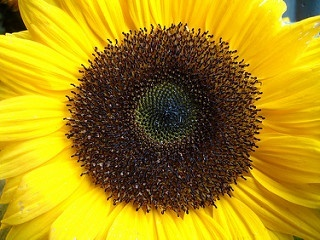

In [ ]:
# View an image from the test dataset
image = cv2.imread('/content/content/flowers/test/Image_2.jpg')
cv2_imshow(image)

In [ ]:
# Check the pixel dimensions of the loaded image
image.shape

(240, 320, 3)

In [ ]:
# Set the parameters for the training data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                 preprocessing_function = preprocess_input,
                                 validation_split = 0.1,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)

# Set the parameters for training the neural network (NN)
train_generator = train_datagen.flow_from_directory(directory = "/content/content/flowers/train", 
                                                  batch_size = 32, 
                                                  shuffle = True,
                                                  class_mode = "categorical", 
                                                  target_size = (224,224),
                                                  subset = "training")

# Set the parameters for testing the NN's performance on the validation data
valid_generator=train_datagen.flow_from_directory(directory = "/content/content/flowers/train", 
                                                  batch_size = 32, 
                                                  shuffle = True, 
                                                  class_mode = "categorical", 
                                                  target_size = (224,224),
                                                  subset = "validation")

Found 2474 images belonging to 5 classes.
Found 272 images belonging to 5 classes.


In [ ]:
# Set the rescaling parameters for the test images
test_datagen=ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)

# Set the parameters for testing the NN's performance on the test data
test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  x_col="filename",
                                                  directory="/content/content/flowers/test", 
    class_mode=None, target_size=(224,224), batch_size=1, shuffle = False)

Found 924 validated image filenames.


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
vgg_16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg_16.layers:
  layer.trainable = False

In [ ]:
# Get the number of flower classes based on the number of training image folders
folders = glob('/content/content/flowers/train/*')

In [ ]:
# Flatten the input
x = tf.keras.layers.Flatten()(vgg_16.output)

# Define parameters for predictions
prediction = tf.keras.layers.Dense(len(folders), activation='softmax')(x)

# Generate model
model = tf.keras.models.Model(inputs=vgg_16.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization methods to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# This package stops model training when the specified metric (e.g. accuracy) stops improving
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Set callbacks to stop NN training

stopper = EarlyStopping(monitor = 'val_accuracy',
                                  mode = 'max', # to stop training when accuracy has maxed out
                                  patience = 5 # to prevent training from stopping prematurely if accuracy declined during one epoch
                                  )

# Reduce learning rate when loss has stopped decreasing
plateau = ReduceLROnPlateau(monitor='loss')

In [ ]:
# Perform training on NN
history = model.fit(train_generator,
                            epochs=15,
                            validation_data=valid_generator,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(valid_generator),
                            callbacks = [stopper, plateau])

Epoch 1/15
78/78 [==============================] - 34s 440ms/step - loss: 0.3058 - accuracy: 0.8945 - val_loss: 0.5612 - val_accuracy: 0.8162
Epoch 2/15
78/78 [==============================] - 34s 441ms/step - loss: 0.2190 - accuracy: 0.9220 - val_loss: 0.5708 - val_accuracy: 0.7721
Epoch 3/15
78/78 [==============================] - 34s 439ms/step - loss: 0.1626 - accuracy: 0.9519 - val_loss: 0.4614 - val_accuracy: 0.8382
Epoch 4/15
78/78 [==============================] - 34s 437ms/step - loss: 0.1393 - accuracy: 0.9572 - val_loss: 0.5161 - val_accuracy: 0.8272
Epoch 5/15
78/78 [==============================] - 34s 437ms/step - loss: 0.1176 - accuracy: 0.9697 - val_loss: 0.5958 - val_accuracy: 0.8051
Epoch 6/15
78/78 [==============================] - 34s 438ms/step - loss: 0.1011 - accuracy: 0.9757 - val_loss: 0.5423 - val_accuracy: 0.8272
Epoch 7/15
78/78 [==============================] - 35s 443ms/step - loss: 0.0950 - accuracy: 0.9762 - val_loss: 0.7621 - val_accuracy: 0.7757

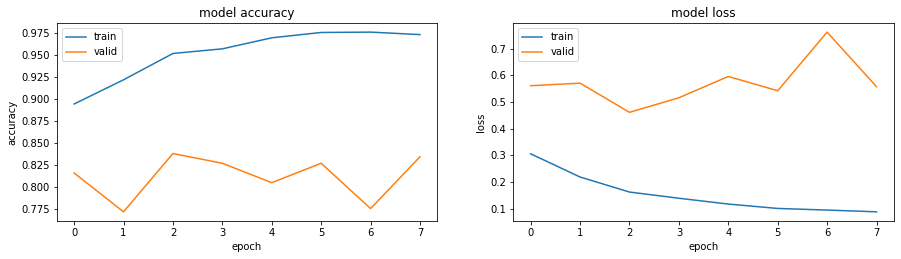

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize = (15,8)) 

# Plot a line graph comparing the model accuracy across epochs on training and validation data   
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

# Plot a line graph comparing the model loss across epochs on training and validation data       
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# Save the model to a file
model.save("model.h52")
print("Saved model to disk")

# Load the model from the file
from tensorflow.keras.models import load_model
model_1 = load_model('model.h52')

INFO:tensorflow:Assets written to: model.h52/assets
Saved model to disk


In [ ]:
# Generate model predictions from test data
preds=model_1.predict(test_generator,batch_size=1)

In [ ]:
# View the class prediction for the first test image
preds[0]

array([8.5063846e-07, 1.1795464e-07, 2.3755112e-07, 9.9999714e-01,
       1.6299401e-06], dtype=float32)

In [ ]:
# Convert numerical class predictions to flower names and save the name predictions to a list
predictions = []
for item in preds:
  if np.argmax(item) == 0:
    predictions.append('daisy')
  elif np.argmax(item) == 1:
    predictions.append('dandelion')
  elif np.argmax(item) == 2:
    predictions.append('rose')
  elif np.argmax(item) == 3:
    predictions.append('sunflower')
  else:
    predictions.append('tulip')

In [ ]:
# Convert the list of predictions to a dataframe for easier viewing
predictions_df = pd.DataFrame(predictions)

In [ ]:
# View the first few predictions
predictions_df.head()

,0
0,sunflower
1,sunflower
2,dandelion
3,sunflower
4,rose


In [ ]:
# Rename the column header to follow the competition submission format
predictions_df = predictions_df.rename(columns = {0 : 'prediction'})
predictions_df.head()

,prediction
0,sunflower
1,sunflower
2,dandelion
3,sunflower
4,rose


In [ ]:
# Save the predictions to a CSV file
predictions_df.to_csv('final_17.csv',index=False)

# Download the csv file locally
from google.colab import files        
files.download('final_17.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **NasNetLarge** 
#### Smaller Validation Set (10% and <1% validation sizes were tested), Tuned Augmentation Parameters  - 	around 85% competition accuracy
#### 30% Validation Size, Tuned Augmentation Parameters - 83.98268% competition accuracy

In [ ]:
import math

In [ ]:
# Compute for train-validation split based on the method of Guyon (1997)

val_split_nnl = (1 / math.sqrt(2439365))

train_split_nnl = 1 - val_split_nnl

print('Train-validation split for NNL:', train_split_nnl, '/', val_split_nnl)

Train-validation split for NNL: 0.9993597322813894 / 0.0006402677186105463


In [ ]:
train_datagen_nnl = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_input,
                                 validation_split = val_split_nnl,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 brightness_range=[0.3,0.9],
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 )

train_generator_nnl = train_datagen_nnl.flow_from_directory(directory="/content/content/flowers/train", 
                                                  batch_size=32, 
                                                  shuffle=True,
                                                  class_mode="categorical", 
                                                  target_size=(331,331),
                                                  subset="training")

valid_generator_nnl = train_datagen_nnl.flow_from_directory(directory="/content/content/flowers/train", 
                                                  batch_size=32, 
                                                  shuffle=True, 
                                                  class_mode="categorical", 
                                                  target_size=(331,331),
                                                  subset="validation")

Found 2746 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


In [ ]:
test_datagen_nnl = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)

test_generator_nnl = test_datagen_nnl.flow_from_dataframe(dataframe=test,
                                                  x_col="filename",
                                                  directory="/content/content/flowers/test", 
    class_mode=None, target_size=(331,331), batch_size=1, shuffle = False)

Found 924 validated image filenames.


In [ ]:
from keras.applications.nasnet import NASNetLarge

In [ ]:
# add preprocessing layer to the front of network
nasnetlarge = NASNetLarge(weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in nasnetlarge.layers:
  layer.trainable = False

In [ ]:
from keras.layers import Flatten
from keras.models import Model

In [ ]:
# Flatten input
x_nasnetlarge = Flatten()(nasnetlarge.output)

prediction_nasnetlarge = Dense(len(folders), activation='softmax')(x_nasnetlarge)

# create a model object
model_nasnetlarge_ = Model(inputs=nasnetlarge.input, outputs=prediction_nasnetlarge)

# view the structure of the model
model_nasnetlarge_.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_520 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization methods to use
model_nasnetlarge_.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
stopperz = EarlyStopping(monitor = 'accuracy',
                                  mode = 'max', # to stop training when accuracy has maxed out
                                  patience = 5 # to prevent training from stopping prematurely if accuracy declined during one epoch
                                  )

plateauz = ReduceLROnPlateau(monitor='loss')

In [ ]:
history_nnl = model_nasnetlarge_.fit(train_generator_nnl,
                            epochs=15,
                            validation_data=valid_generator_nnl,
                            steps_per_epoch=len(train_generator_nnl),
                            validation_steps=len(valid_generator_nnl),
                            callbacks = [stopperz, plateauz])

Epoch 1/15
86/86 [==============================] - 120s 1s/step - loss: 9.7309 - accuracy: 0.6244
Epoch 2/15
86/86 [==============================] - 106s 1s/step - loss: 5.9600 - accuracy: 0.8144
Epoch 3/15
86/86 [==============================] - 105s 1s/step - loss: 6.2116 - accuracy: 0.8121
Epoch 4/15
86/86 [==============================] - 105s 1s/step - loss: 5.9409 - accuracy: 0.8417
Epoch 5/15
86/86 [==============================] - 105s 1s/step - loss: 5.5683 - accuracy: 0.8482
Epoch 6/15
86/86 [==============================] - 105s 1s/step - loss: 5.1755 - accuracy: 0.8664
Epoch 7/15
86/86 [==============================] - 105s 1s/step - loss: 5.5506 - accuracy: 0.8783
Epoch 8/15
86/86 [==============================] - 105s 1s/step - loss: 4.7630 - accuracy: 0.8917
Epoch 9/15
86/86 [==============================] - 105s 1s/step - loss: 5.6739 - accuracy: 0.8789
Epoch 10/15
86/86 [==============================] - 105s 1s/step - loss: 5.5277 - accuracy: 0.8901
Epoch 11/

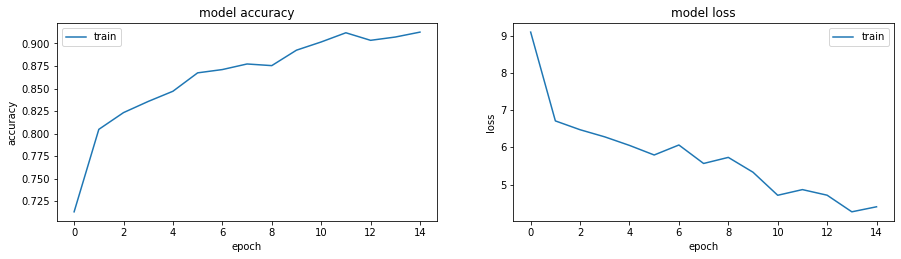

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_nnl.history['accuracy'])  
#plt.plot(history_nnl.history['val_accuracy'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_nnl.history['loss'])  
#plt.plot(history_nnl.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
model_nasnetlarge_.save("model_nnl_g.h5")
print("Saved model to disk")

from tensorflow.keras.models import load_model
model_nnl_1 = load_model('model_nnl_g.h5')

Saved model to disk


In [ ]:
preds_nnl = model_nasnetlarge_.predict(test_generator_nnl,batch_size=1)

In [ ]:
# Show the prediction for the first test image
preds_nnl[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
# Generate labels for the numerical predictions
predictions_nnl = []
for item in preds_nnl:
  if np.argmax(item) == 0:
    predictions_nnl.append('daisy')
  elif np.argmax(item) == 1:
    predictions_nnl.append('dandelion')
  elif np.argmax(item) == 2:
    predictions_nnl.append('rose')
  elif np.argmax(item) == 3:
    predictions_nnl.append('sunflower')
  else:
    predictions_nnl.append('tulip')

In [ ]:
predictions_nnl_df = pd.DataFrame(predictions_nnl)

In [ ]:
predictions_nnl_df.head()

,0
0,sunflower
1,sunflower
2,dandelion
3,rose
4,rose


In [ ]:
predictions_nnl_df = predictions_nnl_df.rename(columns = {0 : 'prediction'})
predictions_nnl_df.head()

,prediction
0,sunflower
1,sunflower
2,dandelion
3,rose
4,rose


In [ ]:
predictions_nnl_df.to_csv('final_19.3.csv',index=False)

# To download the csv file locally
from google.colab import files        
files.download('final_19.3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **InceptionResnetV2** 

In [ ]:
train_datagen_irn = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_input,
                                 validation_split = 0.1,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 brightness_range=[0.3,0.9],
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 )


train_generator_irn = train_datagen_irn.flow_from_directory(directory="/content/content/flowers/train", 
                                                  batch_size=32, 
                                                  shuffle=True,
                                                  class_mode="categorical", 
                                                  target_size=(299,299),
                                                  subset="training")

valid_generator_irn = train_datagen_irn.flow_from_directory(directory="/content/content/flowers/train", 
                                                  batch_size=32, 
                                                  shuffle=True, 
                                                  class_mode="categorical", 
                                                  target_size=(299,299),
                                                  subset="validation")

Found 2474 images belonging to 5 classes.
Found 272 images belonging to 5 classes.


In [ ]:
test_datagen_irn = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)

test_generator_irn = test_datagen_irn.flow_from_dataframe(dataframe=test,
                                                  x_col="filename",
                                                  directory="/content/content/flowers/test", 
    class_mode=None, target_size=(299,299), batch_size=1, shuffle = False)

Found 924 validated image filenames.


In [ ]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
# add preprocessing layer to the front of network
irn = InceptionResNetV2(weights='imagenet', include_top=False, pooling='max')

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in irn.layers:
  layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x_irn = Flatten()(irn.output)

prediction_irn = Dense(len(folders), activation='softmax')(x_irn)

# create a model object
model_irn = Model(inputs=irn.input, outputs=prediction_irn)

# view the structure of the model
model_irn.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_780 (Activation)     (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model_irn.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
stopperz = EarlyStopping(monitor = 'val_accuracy',
                                  mode = 'max', # to stop training when accuracy has maxed out
                                  patience = 5 # to prevent training from stopping prematurely if accuracy declined during one epoch
                                  )

plateauz = ReduceLROnPlateau(monitor='loss')

In [ ]:
history_irn = model_irn.fit(train_generator_irn,
                            epochs=15,
                            validation_data=valid_generator_irn,
                            steps_per_epoch=len(train_generator_irn),
                            validation_steps=len(valid_generator_irn),
                            callbacks = [stopperz, plateauz])

Epoch 1/15
78/78 [==============================] - 85s 969ms/step - loss: 2.6417 - accuracy: 0.3655 - val_loss: 1.1621 - val_accuracy: 0.5809
Epoch 2/15
78/78 [==============================] - 72s 920ms/step - loss: 0.9881 - accuracy: 0.6550 - val_loss: 0.9962 - val_accuracy: 0.6801
Epoch 3/15
78/78 [==============================] - 72s 918ms/step - loss: 0.8155 - accuracy: 0.7166 - val_loss: 1.2578 - val_accuracy: 0.6213
Epoch 4/15
78/78 [==============================] - 72s 917ms/step - loss: 0.8463 - accuracy: 0.7396 - val_loss: 0.9891 - val_accuracy: 0.6507
Epoch 5/15
78/78 [==============================] - 72s 917ms/step - loss: 0.6870 - accuracy: 0.7676 - val_loss: 0.8934 - val_accuracy: 0.7022
Epoch 6/15
78/78 [==============================] - 71s 914ms/step - loss: 0.6321 - accuracy: 0.7750 - val_loss: 0.6609 - val_accuracy: 0.7684
Epoch 7/15
78/78 [==============================] - 72s 917ms/step - loss: 0.5853 - accuracy: 0.8001 - val_loss: 0.7470 - val_accuracy: 0.7390

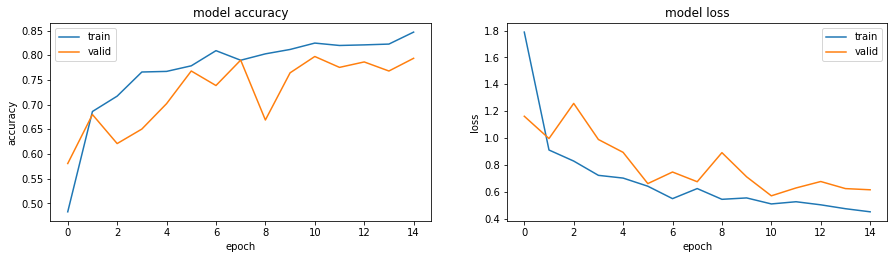

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_irn.history['accuracy'])  
plt.plot(history_irn.history['val_accuracy'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_irn.history['loss'])  
plt.plot(history_irn.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
model_irn.save("model_irn.h5")
print("Saved model to disk")

from tensorflow.keras.models import load_model
model_irn_1 = load_model('model_irn.h5')

Saved model to disk


In [ ]:
preds_irn = model_irn.predict(test_generator_irn, batch_size=1)

In [ ]:
# Show the prediction for the first test image
preds_irn[0]

array([2.3675812e-03, 1.5216271e-04, 1.0304184e-04, 9.9725217e-01,
       1.2503202e-04], dtype=float32)

In [ ]:
# Generate labels for the numerical predictions
predictions_irn = []
for item in preds_irn:
  if np.argmax(item) == 0:
    predictions_irn.append('daisy')
  elif np.argmax(item) == 1:
    predictions_irn.append('dandelion')
  elif np.argmax(item) == 2:
    predictions_irn.append('rose')
  elif np.argmax(item) == 3:
    predictions_irn.append('sunflower')
  else:
    predictions_irn.append('tulip')

In [ ]:
predictions_irn_df = pd.DataFrame(predictions_irn)

In [ ]:
predictions_irn_df.head()

,0
0,sunflower
1,sunflower
2,dandelion
3,tulip
4,rose


In [ ]:
predictions_irn_df = predictions_irn_df.rename(columns = {0 : 'prediction'})
predictions_irn_df.head()

,prediction
0,sunflower
1,sunflower
2,dandelion
3,tulip
4,rose


In [ ]:
predictions_irn_df.to_csv('final_irn.csv',index=False)

# To download the csv file locally
from google.colab import files        
files.download('final_irn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>